In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from matplotlib.widgets import Button 
import matplotlib
from ipywidgets import interact, IntSlider, Dropdown
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
matplotlib.use('TkAgg')

In [3]:
### AIM ###
#Visualizing aggregated data and loading in yield and take all buildup data

soil_temp_raw = pd.read_csv('combined_soiltemp_weather_data.csv')

#Finding the averaged environmental features per week between 2016-2020
soil_temp_soil = soil_temp_raw.copy()
soil_temp_soil = soil_temp_soil[['day', 'g10t', 'sun', 'dryb', 'rad']]
soil_temp_soil['day'] = pd.to_datetime(soil_temp_soil['day'])
soil_temp_soil = pd.DataFrame(soil_temp_soil)
soil_temp_soil = soil_temp_soil[(soil_temp_soil['day'].dt.year >= 2016) & (soil_temp_soil['day'].dt.year <= 2020)]
soil_temp_soil = (soil_temp_soil.groupby(pd.Grouper(key = 'day', freq = 'W'))[['g10t', 'sun', 'dryb', 'rad']].mean())

#Avergaing the plant aggregate buildup data by year between 2016-2020
df = pd.read_excel("760_all.xlsx") 
df['root_pct'] = df["ww_rts_tkal_cnt"] / df["ww_rts_cnt"]
df.dropna(subset = ['root_pct'], inplace=True)
df['plant_pct'] = df['ww_pla_tkal_cnt'] / df['ww_pla_cnt']
df_groupby = df.groupby(['sample_date', 'variety_factor_level'])[['root_pct', 'plant_pct']].mean().reset_index()
df_groupby['sample_date'] = pd.to_datetime(df_groupby['sample_date'])
df_groupby.sample(10)

,sample_date,variety_factor_level,root_pct,plant_pct
7,2017-08-15,Cadenza,0.551997,0.939444
24,2020-08-22,Barley - KWS Cassia,0.227930,0.579583
11,2017-08-15,Xi19,0.669281,0.985000
20,2019-08-22,Duxford,0.367704,0.829141
28,2020-08-22,Hereward,0.390386,0.799980
1,2016-08-22,Cadenza,0.543192,0.871149
25,2020-08-22,Cadenza,0.219272,0.595873
12,2018-08-22,Barley - KWS Cassia,0.542993,0.935000
15,2018-08-22,Hereford,0.593550,0.921111
5,2016-08-22,Xi19,0.560143,0.925278


In [8]:
### AIM ###
#Editing the data data to conform to date-time format
#Incorporate sliding window model and filter 2016-2020

### PROCESS ###
# Returns the monday for each week
def date_create(year, week):
    return datetime.date.fromisocalendar(year, week, 1)

sliding_window = pd.read_csv('sliding_window_data.csv')

#Only include columns which include the name year or rain
slide_rain = sliding_window.filter(regex = 'year|rain', axis = 1)
slide_rain = slide_rain.rename(columns = lambda column: column.replace('rain,', 'Week'))
slide_rain = slide_rain.melt(id_vars = 'year', var_name = 'week', value_name = 'value')

#Getting the week numbers
slide_rain['week'] = slide_rain['week'].str.extract('(\d+)').astype(int)
slide_rain['year'] = slide_rain['year'].astype(int)

#Filtering and obtaining the the data
slide_rain = slide_rain.sort_values(by = ['year', 'week'])
slide_rain = slide_rain[(slide_rain['year'] >= 2016) & (slide_rain['year'] <= 2020)]
slide_rain['day'] = slide_rain.apply(lambda row: date_create(int(row['year']), int(row['week'])), axis = 1)

df['sample_date'] = pd.to_datetime(df['sample_date'])
slide_rain['day'] = pd.to_datetime(slide_rain['day'])
slide_rain['day'] = slide_rain['day'] - pd.Timedelta(days=1)

#Merging the environmental data with the sliding window rainfall
merge_df = pd.merge(soil_temp_soil, slide_rain, on = 'day', how = "left")
merge_df = merge_df.drop(merge_df.tail(2).index)
merge_df.drop(['year', 'week'], axis = 1, inplace = True)
merge_df.rename(columns = {'value':'rain'}, inplace = True)

,year,week,value,day
16,2016,1,5.185714,2016-01-03
42,2016,2,1.342857,2016-01-10
68,2016,3,1.028571,2016-01-17
94,2016,4,2.742857,2016-01-24
120,2016,5,2.800000,2016-01-31
...,...,...,...,...
1242,2020,48,0.285714,2020-11-22
1268,2020,49,2.171429,2020-11-29
1294,2020,50,4.085714,2020-12-06
1320,2020,51,2.542857,2020-12-13


In [7]:
### PROCESS ###
#Importing yield data and grouping the grain yield by harvest year and variety factor level
yield_data = pd.read_excel("Yield_760.xlsx") 
yield_data['harvest_year'] = pd.to_datetime(yield_data['harvest_year'])
avg_grain = (yield_data.assign(year=lambda x: pd.to_datetime(x['harvest_year'])).groupby(['harvest_year', 'variety_factor_level'], as_index=False)['ww_grnyld']
      .mean().rename(columns={'ww_grnyld': 'average_grain_yield'}))

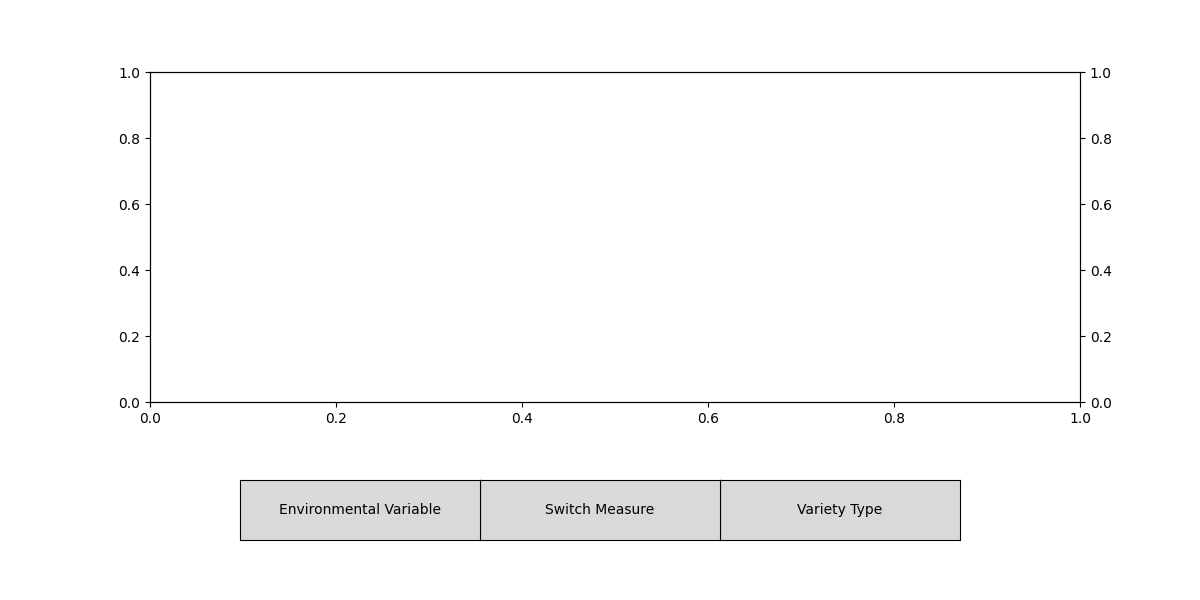

In [9]:
### AIM ###
#Creating an interactive barplot for observing the changes of plant features from environmental variables
#This model can swap between wheat varieties

#Creates the buttons and their limitations
#Creates the axis and global variables

#3 buttons were created: one for Variety type, Disease Buildup, and Environmental Feature

### PROCESS ###
%matplotlib widget
global index_val
global env_index
global bar_index
index_val = 0
env_index = -1
bar_index = 0

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.subplots_adjust(bottom=0.33)

#Creating buttons
ax2 = ax1.twinx()
variety = yield_data['variety_factor_level'].unique().tolist()
bar_width = pd.Timedelta(days = 150)

button_choice = plt.axes([0.60, 0.1, 0.2 ,0.1])
button = Button(button_choice, 'Variety Type')

button_bar_ax = plt.axes([0.40, 0.1, 0.2 ,0.1])
button_bar = Button(button_bar_ax, 'Switch Measure')

button_env_ax = plt.axes([0.20, 0.1, 0.2 ,0.1])
button_env = Button(button_env_ax, 'Environmental Variable')

#List for environmental and plant values 
env_values = [('Soil Temperature (C) Per Day', 'g10t', 'purple', 'Soil Temperature (C)'),('Sunlight Per Day', 'sun', 'green', 'Sunlight'),
    ('Rainfall per Week Average (mm)', 'value', 'blue', 'Rainfall (mm)')]

bar_values = [('Grain Count', 'average_grain_yield', 'firebrick', 'Grain Count (t/ha)'), ('Average Root % Infection', 'root_pct', 'green', 'Root Infected %'),
    ('Average Plant % Infection', 'plant_pct', 'orange', 'Plant Infected %')]

first_values =  [env[0] for env in env_values]
bar_labels = [bar[0] for bar in bar_values]

#Function for switching between the environmental types and varieties
def plot_specific_variety(index_val, env_type = 'Rainfall', bar_val = 'Grain Count'):
    ax2.clear()
    variety_level = variety[index_val]
    var_subset = avg_grain[avg_grain['variety_factor_level'] == variety_level]
    bar_subset = df_groupby[df_groupby['variety_factor_level'] == variety_level]
    bar_label, bar_col, bar_color, bar_ylabel = bar_values[bar_index]

    if (bar_index == 0):
        ax2.bar(var_subset['harvest_year'] - bar_width, var_subset['average_grain_yield'], color = bar_color, width = bar_width, alpha = 0.5)
        ax2.set_ylabel('Grain Yield (t/ha)', color = 'red')
        ax2.yaxis.set_label_position("right")
        ax2.set_ylim(0, avg_grain['average_grain_yield'].max())
        ax2.set_title(f'{variety[index_val]}: {env_type} measuring {bar_val}', loc = 'center')

    if (bar_index in [1,2]):
        ax2.bar(bar_subset['sample_date'] - bar_width, bar_subset[bar_col], color = bar_color, width = bar_width, alpha = 0.5)
        ax2.set_ylabel(bar_val, color = bar_color)
        ax2.yaxis.set_label_position("right")
        ax2.set_ylim(0, df_groupby[bar_col].max())
        ax2.set_title(f'{variety[index_val]}: {env_type} measuring {bar_val}', loc = 'center')


def on_click_env(event):
    ax1.clear()
    global env_index
    env_index = (env_index + 1) % len(env_values)
    label, yvalue, color, ylabel = env_values[env_index]

    if (env_index in [0,1]):
        plot_specific_variety(index_val, first_values[env_index], bar_labels[bar_index])
        sns.lineplot(data = soil_temp_soil, x = 'day', y = yvalue, label = label, color = color, ax = ax1)
        ax1.set_ylabel(ylabel, color = color)
        ax1.get_legend().remove()
        fig.canvas.draw_idle()
        
    if (env_index == 2):
        plot_specific_variety(index_val, first_values[env_index], bar_labels[bar_index])
        sns.lineplot(data = slide_rain, x = 'day', y = yvalue, label = label, color = color, ax = ax1)
        ax1.set_ylabel(ylabel, color = color)
        ax1.get_legend().remove()
        fig.canvas.draw_idle()


def on_click(event):
    global index_val
    index_val = (index_val + 1) % len(variety)
    plot_specific_variety(index_val, first_values[env_index], bar_labels[bar_index])
    fig.canvas.draw_idle()

def on_click_bar(event):
    global bar_index
    bar_index = (bar_index + 1) % len(bar_values)
    plot_specific_variety(index_val, first_values[env_index], bar_labels[bar_index])
    fig.canvas.draw_idle()


button.on_clicked(on_click)
button_env.on_clicked(on_click_env)
button_bar.on_clicked(on_click_bar)
plt.show()

### RESULTS ###
#Model works as intended
#Dual axis model where you can switch between environmental and response output (switch measure)
#Variety type does not alter the color, title of graph changes each time you swap a variable

In [14]:
### PROCESS ###
#Creating groupby table including the weekly means for each environmental feature
corr_table = merge_df
corr_table['day'] = pd.to_datetime(corr_table['day'])
corr_table = pd.DataFrame(corr_table)
corr_table = corr_table[(corr_table['day'].dt.year >= 2016) & (corr_table['day'].dt.year <= 2020)]
corr_table = (corr_table.groupby(pd.Grouper(key = 'day', freq = 'W'))[['g10t', 'dryb', 'sun', 'rain', 'rad']].sum())
corr_table.head(5)

,g10t,dryb,sun,rain,rad
day,,,,,
2016-01-03,7.400000,5.033333,0.033333,5.185714,101.100000
2016-01-10,6.728571,5.285714,1.714286,1.342857,217.571429
2016-01-17,4.528571,1.785714,2.685714,1.028571,265.228571
2016-01-24,3.014286,2.442857,2.685714,2.742857,282.728571
2016-01-31,6.528571,7.328571,2.114286,2.800000,279.400000


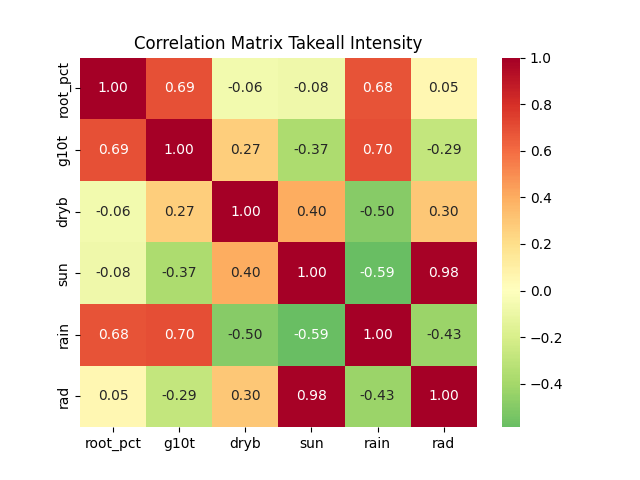

In [15]:
### AIM ###
#Finding a correlation matrix between the root percent infected environmental variables
#Used for years 2019-2020 to track take all increase rather than the decline interval

### PROCESS ###
#Assigning month and year columns for easier filtering
corr_table['year'] = corr_table.index.year
corr_table = corr_table[corr_table['year'].isin([2016, 2017, 2018, 2019])]
corr_table['week'] = corr_table.index.isocalendar().week.astype(int)

#Assigning which months 
month_table = corr_table[(corr_table['week'] >= 0) & (corr_table['week'] <= 35)]

#Selecting the overall mean for the week interval by year
interval_means = (month_table.groupby(['year'])[['g10t', 'dryb', 'sun', 'rain', 'rad']].sum().reset_index())

#Creating correlation plot between environmental features and root percent, merging interval means table by year
df_variety = df_groupby
df_variety['year'] = df_variety['sample_date'].dt.year
merged_corr = pd.merge(df_variety[['year', 'root_pct']], interval_means, on='year', how='inner')
corr_matrix = merged_corr[['root_pct', 'g10t', 'dryb', 'sun', 'rain', 'rad']].corr()

plt.close('all')
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn_r', center=0, fmt=".2f")
plt.title('Correlation Matrix Takeall Intensity')
plt.show()

### RESULTS ###
#Summed Rain and Soil Temperature are the greatest correlated environmental influencers

In [21]:
### AIM ###
#Create a function that plots the correlation between the averaged environmental values per week and the root percentage
#Should be able to slide the weeks to choose custom intervals
#Display a heat map for the oveall correlation within the week interval

### PROCESS ### 
#Assigning function for customization 
variety_sorted = sorted(df_groupby['variety_factor_level'].unique())

def corr_function(start_week, end_week, variety_type):
    month_table = corr_table[(corr_table['week'] >= start_week) &(corr_table['week'] <= end_week)]
    interval_means = (month_table.groupby(['year'])[['g10t', 'dryb', 'sun', 'rain']].mean().reset_index())
    df_variety = df_groupby[df_groupby['variety_factor_level'] == variety_type].copy()
    df_variety['year'] = df_variety['sample_date'].dt.year
    merged_corr = pd.merge(df_variety[['year', 'root_pct']], interval_means, on = 'year', how = 'inner')
    corr_matrix = merged_corr[['root_pct', 'g10t', 'dryb', 'sun', 'rain']].corr()

    #Implementing the lineplot
    time_interval = []
    for week in range(start_week, end_week + 1):
        week_date = month_table[month_table['week'] == week]
        wk_merge = pd.merge(df_variety[['year', 'root_pct']], week_date, on = 'year', how = 'inner')
        time_interval.append({
                'week': week,
                'g10t': wk_merge[['root_pct', 'g10t']].corr().iloc[0, 1],
                'dryb': wk_merge[['root_pct', 'dryb']].corr().iloc[0, 1],
                'sun': wk_merge[['root_pct', 'sun']].corr().iloc[0, 1],
                'rain': wk_merge[['root_pct', 'rain']].corr().iloc[0, 1],})
        
    corr_df = pd.DataFrame(time_interval)
    plt.figure(figsize = (10,5))
    for col in ['g10t', 'dryb', 'sun', 'rain']:
        plt.plot(corr_df['week'], corr_df[col], marker = 'o', label = col)
  
    plt.axhline(0, color = 'gray', linestyle = '-', linewidth = 1)
    plt.title(f'Weekly Correlation Trend: {variety_type}')
    plt.xlabel('Week of Year')
    plt.ylabel('Correlation (R)')
    plt.legend()
    plt.grid(alpha = 0.2)
    plt.show()
        
    plt.figure(figsize = (8,4))
    sns.heatmap(corr_matrix, annot=True, cmap = 'coolwarm', center = 0)
    plt.show()


### RESULTS ###
#Correlations within lower week intervals such as 5-10 show expected correlations between environmental features and root percent infected

In [22]:
# Interactive slider widget
@interact(
    start_week = IntSlider(value = 0, min = 0, max = 35, step = 1, description = 'Start Week'),
    end_week = IntSlider(value = 35, min = 0, max = 35, step = 1, description = 'End Week'),
    variety_button = Dropdown(options = variety_sorted, value = variety_sorted[0], description = 'Variety')
)

def interactive_corr(start_week, end_week, variety_button):
    if start_week > end_week:
        print("Start should be < End Week")
        return
    corr_function(start_week, end_week, variety_button)

interactive(children=(IntSlider(value=0, description='Start Week', max=35), IntSlider(value=35, description='E…

In [34]:
#Formatting datetime into international standard ISO8601 format
df_reg = df_groupby.copy()
df_reg['sample_date'] = pd.to_datetime(df_reg['sample_date'].astype(str), format='ISO8601')
df_reg['sample_date'] = df_reg['sample_date'].dt.year
df_reg = df_reg.rename(columns = {'sample_date': 'year'})
df_reg = df_reg.loc[:, ~df_reg.columns.duplicated()]

In [30]:
### AIM ###
#Create a function to interpret input values and filter weeks to make a generalized linear model

### PROCESS ###
def regression_function(start_week, end_week):
    month_table = corr_table[(corr_table['week'] >= start_week) & (corr_table['week'] <= end_week)]
    interval_means = (month_table.groupby(['year'])[['g10t', 'dryb', 'sun', 'rain']].sum().reset_index() )
    merged_reg = pd.merge(df_reg[['year', 'root_pct', 'variety_factor_level']], interval_means, on = 'year', how = 'right')
    model = smf.ols('root_pct ~ g10t + rain + C(variety_factor_level)', data = merged_reg).fit()
    
    print(model.summary())

In [31]:
#Creation of interactable sliders for start and end week
@interact(
    start_week = IntSlider(value = 0, min = 0, max = 34, step = 1, description = 'Start Week'),
    end_week = IntSlider(value = 34, min = 0, max = 34, step = 1, description = 'End Week'),
)

def interactive_reg(start_week, end_week):
    if start_week > end_week:
        print("Start should be < End Week")
        return
    regression_function(start_week, end_week)

interactive(children=(IntSlider(value=0, description='Start Week', max=34), IntSlider(value=34, description='E…

In [35]:
### AIM ###
#Create iterative loop that goes through each possible 5 week interval and records that model metrics
#The top 3 lowest AIC value models are chosen
#Each of the 3 models assessed, and the one where correlation signs are expected is chosen, this is because the model finds the best AIC value
#and not the correlation signs and weight, so the top 3 have to be manually inspected

### PROCESS ###
results = []

for start in range(0, 30):       
    end = start + 5
    interval_means = (corr_table[(corr_table['week'] >= start) & (corr_table['week'] <= end)].groupby('year')[['g10t', 'sun', 'rain', 'dryb']].sum().reset_index())
    merged = pd.merge(df_reg[['year', 'root_pct', 'variety_factor_level']], interval_means, on = 'year', how = 'inner')
        
    if len(merged) < 3:
            continue
            
    model_reg = smf.ols('root_pct ~ g10t + rain + C(variety_factor_level)', data=merged).fit()
    results.append({'start_week': start, 'end_week': end, 'AIC': model_reg.aic, 'R2': model_reg.rsquared})

results_weather = pd.DataFrame(results)

#best_weeks = results_weather.loc[results_weather['AIC'].idxmin()]
top3_weeks = results_weather.sort_values(by = 'AIC').head(3)
print("Best 3 intervals based on AIC:")
print(top3_weeks)



Best 3 intervals based on AIC:
    start_week  end_week        AIC        R2
19          19        24 -64.395701  0.815846
14          14        19 -64.187795  0.814244
18          18        23 -63.398716  0.808035


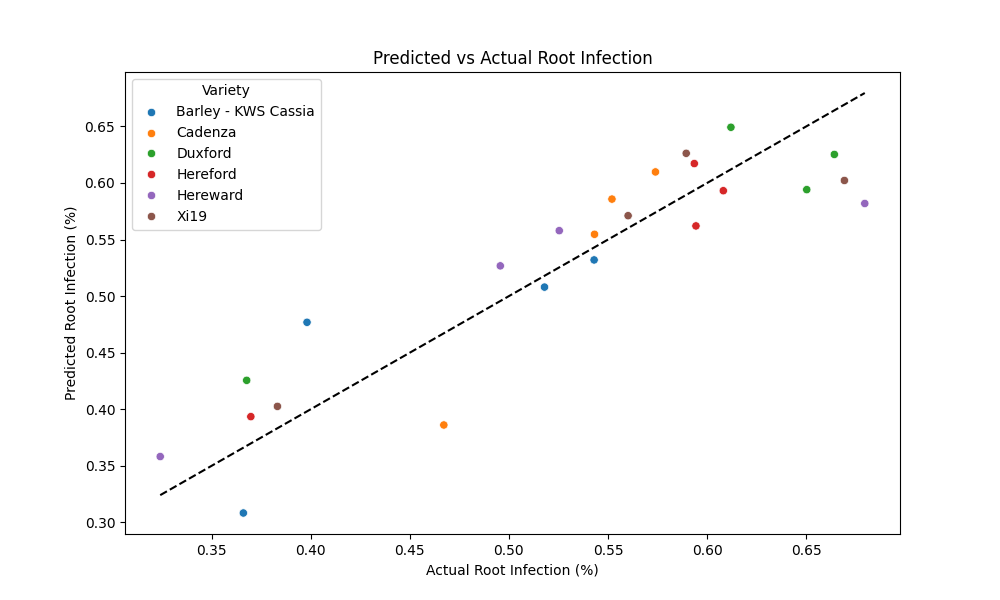

In [37]:
### AIM ###
#Creating a linear model that compares the predicted aggregated values of take all infection percentage and the actual

### PROCESS ###
start_week = 14
end_week = 19
interval_means_2 = (corr_table[(corr_table['week'] >= start_week) & (corr_table['week'] <= end_week)].groupby('year')[['g10t', 'sun', 'rain', 'dryb']].sum().reset_index())
merged_2 = pd.merge(df_reg[['year', 'root_pct', 'variety_factor_level']], interval_means_2, on = 'year', how = 'inner')
model_reg_2 = smf.ols('root_pct ~ g10t + rain + C(variety_factor_level)', data  = merged_2).fit()


#Linear plot displaying the plotted differences between the predicted root and actual
merged_2['predicted'] = model_reg_2.fittedvalues
plt.figure(figsize=(10,6))
sns.scatterplot(data = merged_2, x = 'root_pct', y = 'predicted', hue = 'variety_factor_level')

#Sets boundaries on the model
plt.plot([merged_2['root_pct'].min(), merged_2['root_pct'].max()], [merged_2['root_pct'].min(), merged_2['root_pct'].max()],
         color = 'black', linestyle = '--')

plt.title("Predicted vs Actual Root Infection")
plt.xlabel("Actual Root Infection (%)")
plt.ylabel("Predicted Root Infection (%)")
plt.legend(title = "Variety")
plt.show()

#Hereford and Cadenza the cloest to prediction in the model between weeks 14-19
#Model less accurate with lower Root Infection (%)
